In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
input_dim = mnist.train.images[0].shape[0] #55000instances, each 784 pixel
w = h = int(np.sqrt(input_dim))
from tensorflow.contrib.slim import fully_connected as fc

In [3]:
class Autoencoder(object):
    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
  # build the network and the loss function
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encoder (f)
        # x -> z

        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decoder (g)
        # z -> x'
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss: reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_{hat}) = -\Sigma (x \times \log(x_{hat}) + (1 - x) \times \log(1 - x_{\hat}))
        epsilon = 1e-10
        recon_loss = tf.reduce_sum( #compute the sum of one tensor 
            self.x * tf.log(self.x_hat + epsilon) + (1 - self.x) * tf.log(1 - self.x_hat + epsilon),axis=1)
        self.recon_loss = -tf.reduce_mean(recon_loss)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.recon_loss)

        self.losses = {
            'recon_loss': self.recon_loss,
        }
        return
    
    
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses
  
  # x -> x_hat
    # x_hat is the output layer
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
  
  # x -> z 
    # z is the bottle neck layer
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z


In [4]:
def trainer(model_object, learning_rate=1e-4, batch_size=64, num_epochs=100, n_z=16, log_step=5):
    model = model_object(learning_rate=learning_rate, batch_size=batch_size,n_z=n_z)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
          # get a batch
            batch = mnist.train.next_batch(batch_size)
          # execute the forward and backward path
          # report computed losses
            images, labels = batch
            losses = model.run_single_step(images)
        end_time = time.time()
        if epoch % log_step == 0:
            log_str = '[Epoch: {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}'.format(k, v)
            log_str += '({:.3f}sec/epoch)'.format(end_time - start_time)
            print(log_str)
    print('Done')
    return model

In [5]:
model = trainer(Autoencoder, num_epochs=10, learning_rate=1e-2, batch_size=512)

[Epoch: 0] recon_loss: 175.027(2.874sec/epoch)
[Epoch: 5] recon_loss: 114.929(2.792sec/epoch)
Done


In [6]:
# put the autoencoded image with the original image toghter to compare: right is the original
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
  # test the trained model; reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_recon = model.reconstructor(batch[0])
  
    n = int(np.sqrt(batch_size))
    I_recon = np.empty(shape=(h*n, 2*w*n))
  
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_recon[i * n + j, :].reshape(h, w), batch[0][i * n + j, :].reshape(h, w)),
                axis=1
            )
            I_recon[i * h: (i + 1) * h, j * 2 * w: (j + 1) * 2 * w] = x
    plt.figure(figsize=(10, 20))
    plt.imshow(I_recon, cmap='gray')

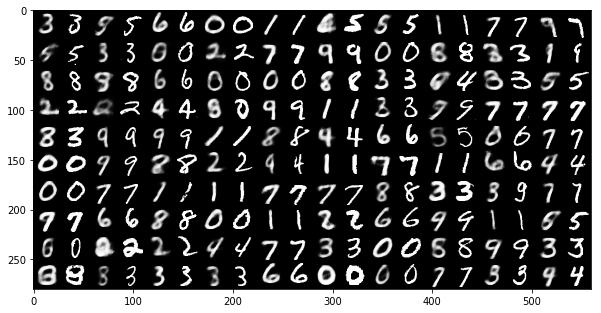

In [7]:
test_reconstruction(model, mnist)

In [76]:
# Train a model with 2d latent space(bottle neck layer)
model_2d = trainer(Autoencoder, n_z=3, num_epochs=10)

[Epoch: 0] recon_loss: 185.815(4.202sec/epoch)
[Epoch: 5] recon_loss: 139.345(3.538sec/epoch)
Done


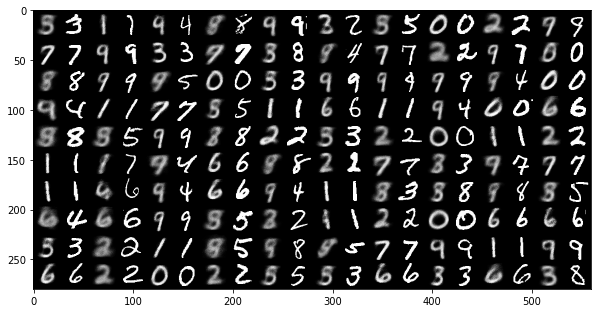

In [77]:
# The dimension of bottle neck layer too small, error will unaccpetable
test_reconstruction(model_2d, mnist)

In [122]:
# Embed the images to bottle neck layer, then show the distribution of images after embedding
def test_transformation(model_2d, mnist, batch_size=3000):
    #batch_size = 100
    assert model_2d.n_z == 3
    batch = mnist.test.next_batch(batch_size) #batch[0] are the images, batch[1] are the labels
    z = model_2d.transformer(batch[0]) # [batch_size, 2]
    plt.figure(figsize=(10, 10))
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1],axis = 1), s=20, cmap='hsv') # color the point by it label(0-9)
    plt.colorbar()
    plt.grid()

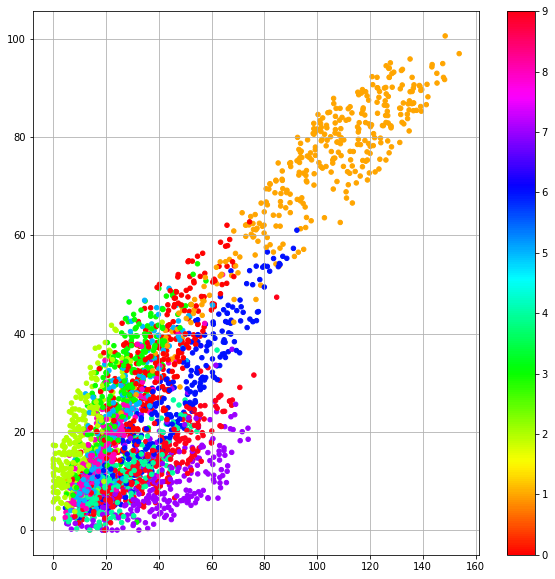

In [123]:
test_transformation(model_2d, mnist) 